# Simulated Annealing for VRPSPD

In [17]:
import random
import copy
import math
import matplotlib.pyplot as plt
import numpy as np

In [18]:
#  Distance of a specific route.
def node_distance(A,B):
    return math.sqrt((A.x-B.x)**2 + (A.y-B.y)**2)
#  Calculate the distance matrix of all nodes
def distance_matrix(Nodes):
    n = len(Nodes)
    matrix = [[0 for i in range(n)] for j in range(n)]
    for i in range(n):
        for j in range(n):
            matrix[i][j] = node_distance(Nodes[i],Nodes[j])
    return matrix

1. Class Node, Class Vehicle and Class Routeplan

In [19]:
class Node():
    def __init__(self,id,x,y,delivery,pickup):
        self.id = id
        self.x = x
        self.y = y
        self.delivery = delivery
        self.pickup = pickup

class Vehicle(): # A vehicle is a route which does not include the depot
    def __init__(self,depot,Capacity,depotload):
        self.depot = depot
        self.Capacity = Capacity
        self.depotload = depotload
        self.load = [] # load at each node
        self.loadchange = [] # load changes at each node, positive value means pickup > delivery
        self.route = []

    def addnode(self,Node):
        self.route.append(Node)
        self.loadchange.append(Node.pickup - Node.delivery) 
        weight = 0
        weight += self.depotload + sum(self.loadchange[:])
        weight = max(0,weight) # if load < 0, set load to 0
        self.load.append(weight)

    def route_length(self): # must be non-empty
        length = 0
        length += node_distance(self.route[0],self.depot)# Add the distance from the start to the first node
        for i in range(len(self.route)-1):
            length += node_distance(self.route[i],self.route[i+1])
        length += node_distance(self.route[-1],self.depot)# Add the distance from the last node to the start node
        return length    
    
    def updateload(self):
        self.load = []
        for i in range(len(self.loadchange)):
            weight = self.depotload + sum(self.loadchange[:i+1])
            weight = max(0,weight)
            self.load.append(weight)

class RoutePlan():
    def __init__(self,depot):
        self.depot = depot
        self.vehicles = []

    def add_vehicle(self,vehicle):
        self.vehicles.append(vehicle)

    def RP_distance(self):
        distance = 0
        for vehicle in self.vehicles:
            distance += vehicle.route_length()
        return distance
    
    def update(self):
        for vehicle in self.vehicles:
            if len(vehicle.route) == 0:
                self.vehicles.remove(vehicle)

2. Generate Nodes and initial solution

In [20]:
# Generate N customers with weights between MINweight and MAXweight
def Generate_Nodes(N):
    Nodes = []
    data = list(set((random.randrange(900), random.randrange(600))for c in range(N)))
    for i in range(N):
        node_i = Node(i+1,data[i][0],data[i][1],random.randrange(10,40),random.randrange(30,50))
        Nodes.append(node_i)
    return Nodes

In [21]:
# Greedy Strategy to generate the initial solution
def Initial_solution(Nodes,depot,Capacity,depotload): #Nodes do not include the depot
    Nodes = copy.deepcopy(Nodes)
    RP = RoutePlan(depot)
    unvisited = list(range(1,len(Nodes)+1))

    while unvisited != []:
        vehicle = Vehicle(depot,Capacity,depotload)
        firstnode = min(unvisited,key = lambda x: node_distance(depot,Nodes[x-1]))
        vehicle.addnode(Nodes[firstnode-1]) # Nodes do not incude the depot
        unvisited.remove(firstnode)

        i = 0
        while vehicle.load[-1] <= vehicle.Capacity and unvisited != []:
            nextnode = sorted(unvisited,key = lambda x: node_distance(vehicle.route[-1],Nodes[x-1]))[i]
            if vehicle.load[-1] + Nodes[nextnode-1].pickup - Nodes[nextnode-1].delivery <= vehicle.Capacity:
                vehicle.addnode(Nodes[nextnode-1])
                unvisited.remove(nextnode)
                i = 0
            else:
                i += 1
                if i == len(unvisited):
                    break
        RP.add_vehicle(vehicle)
    return RP

3. Perturbation Function

In [22]:
def two_optswap(Routeplan):
    RP = copy.deepcopy(Routeplan)
    for vehicle in RP.vehicles:
        route,loadchange,load = vehicle.route,vehicle.loadchange,vehicle.load
        if len(route) > 4:
            i = random.randint(0,len(route)-2)
            j = random.randint(i+1,len(route)-1)
            B,C = route[i],route[j]
            A = route[i-1] if i != 0 else RP.depot
            D = route[j+1] if j != len(route)-1 else RP.depot
            cond1 = node_distance(A,C) + node_distance(B,D) < node_distance(A,B) + node_distance(C,D)
            cond2 = load[i-1] + load[j] < vehicle.Capacity
            if cond1 and cond2:
                route[i], route[j] = route[j], route[i]
                loadchange[i], loadchange[j] = loadchange[j], loadchange[i]                
                vehicle.updateload()
                RP.update()
    return RP

def Reverse(Routeplan):
    RP = copy.deepcopy(Routeplan)
    for vehicle in RP.vehicles:
        route,loadchange = copy.deepcopy(vehicle.route),copy.deepcopy(vehicle.loadchange)
        if len(route) >= 4:
            i = random.randint(0, len(route)-2)
            j = random.randint(i+1, len(route)-1)
            route[i:j+1] = reversed(route[i:j+1])
            loadchange[i:j+1] = reversed(loadchange[i:j+1])
            # Capacity constraint
            if all([load < vehicle.Capacity for load in vehicle.load]):
                vehicle.route = route
                vehicle.loadchange = loadchange
                vehicle.updateload()
            RP.update()
    return RP

def insert(Routeplan,matrix,Nodes):
    RP = copy.deepcopy(Routeplan)
    # Choose a random node from a random vehicle
    from_vehicle = random.randint(0,len(RP.vehicles)-1)
    i = random.randint(0,len(RP.vehicles[from_vehicle].route)-1)
    node = RP.vehicles[from_vehicle].route.pop(i)
    to_nodes_set = sorted(Nodes[1:],key = lambda x: matrix[node.id][x.id]) # Nodes do not include the depot
    to_node = random.choice(to_nodes_set[1:7]) # to_Nodes do not include itself
    for vehicle in RP.vehicles:
        if to_node.id in [node.id for node in vehicle.route]:
            to_vehicle = RP.vehicles.index(vehicle)
            break
    # insert node into to_vehicle
    RP.vehicles[from_vehicle].loadchange.pop(i)       
    RP.vehicles[to_vehicle].route.insert(j,node)
    RP.vehicles[to_vehicle].loadchange.insert(j,node.pickup-node.delivery)
    RP.vehicles[from_vehicle].updateload()
    RP.vehicles[to_vehicle].updateload()
    
    con1 = all([load < RP.vehicles[from_vehicle].Capacity for load in RP.vehicles[from_vehicle].load])
    con2 = all([load < RP.vehicles[to_vehicle].Capacity for load in RP.vehicles[to_vehicle].load])
    if con1 and con2:
        RP.update()
        return RP
    return Routeplan

# Use roulette wheel to determine which operator to use
def roulette(two_optswap,Reverse,insert,matrix,Nodes):
    p = [two_optswap,Reverse,insert]
    r = random.randint(0,2)
    if r == 0:
        return two_optswap
    elif r == 1:
        return Reverse
    else:
        return lambda RP : insert(RP,matrix,Nodes)

4. Plot Routeplan

In [23]:
def PlotRoute(RP):
    plt.figure()
    depot = RP.depot
    plt.plot(depot.x,depot.y,'r,',markersize=20)
    for vehicle in RP.vehicles:
        route = [(depot.x,depot.y)] + [(node.x,node.y) for node in vehicle.route] + [(depot.x,depot.y)]
        plt.plot(*zip(*route),'-o')
    plt.show()
    return 

4. Main Function

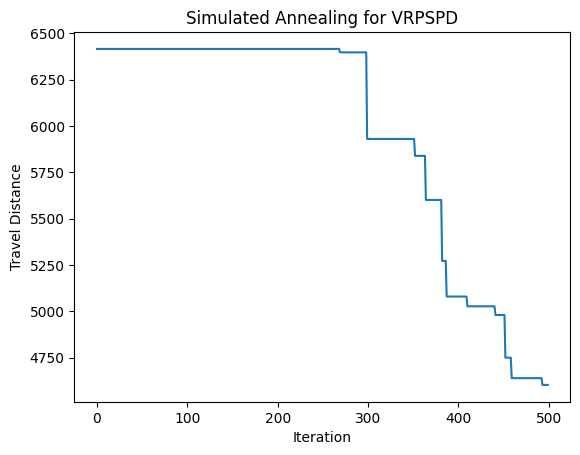

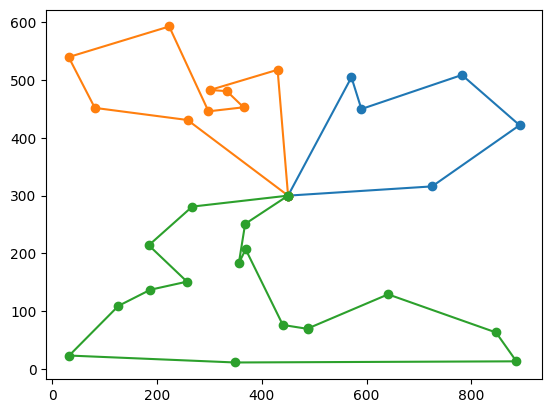

In [24]:
#Generate initial solution
depot = Node(0,450,300,0,0)
customers = Generate_Nodes(30)
Nodes = [depot] + customers
matrix = distance_matrix(Nodes)
alpha = 0.99 # cooling rate
T = 5000 # initial temperature
MaxOutIter = 500 # maximum number of outer iterations
MaxInIter = 1000 # maximum number of inner iterations
RP = Initial_solution(customers,depot,200,50)
bestcost = RP.RP_distance()
best_cost = []

# Simulated annealing
for i in range(MaxOutIter):
    for j in range(MaxInIter):
        newRP = roulette(two_optswap,Reverse,insert,matrix,Nodes)(RP)
        if newRP.RP_distance() < RP.RP_distance():
            RP = newRP
        else:
            if random.random() < math.exp((RP.RP_distance()-newRP.RP_distance())/T):
                RP = newRP
    if RP.RP_distance() < bestcost:
        bestcost = RP.RP_distance()
    best_cost.append(bestcost)
    T = T * alpha
    #No early break

plt.plot(best_cost)
plt.xlabel('Iteration')
plt.ylabel('Travel Distance')
plt.title('Simulated Annealing for VRPSPD')
plt.show()
PlotRoute(RP)